# SVM con *scorings*
Prueba de SVM con los scorings calculados con:

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import warnings
warnings.filterwarnings('ignore')

Carga del DataFrame Principal:

In [44]:
data_dir = './data'
df_cdk2_labels = pd.read_json(F"{data_dir}/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS_AUC_docking_DUD.json")
df_cdk2_labels.head()

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,...,NameLigs,Inhib,Inhib_mass,Labels_conf,AUC_vrd_16x,AUC_vrd_8x,AUC_vina,AUC_ad4_LC,AUC_ad4_LE,AUC_vrd_DUD_8x
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.00,298,92.953020,2,"[8, 13]","[[36, 43], [149, 161]]",...,['STU'],STU,440.0,inact_b,0.730317,0.740724,0.575339,0.634163,0.572172,0.583597
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.00,298,97.315436,1,[8],"[[36, 43]]",...,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a,0.677828,0.683258,0.546154,0.571946,0.483032,0.495684
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.10,298,97.315436,1,[8],"[[36, 43]]",...,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a,0.764706,0.785520,0.580543,0.670814,0.607919,0.523706
1buh,crystal structure of the human cdk2 kinase com...,1998-09-09,2,A,2.60,298,96.308725,2,"[7, 4]","[[40, 46], [295, 298]]",...,[],,,inact_a,0.708145,0.734163,0.535294,0.613348,0.544344,0.433577
1ckp,human cyclin dependent kinase 2 complexed with...,1999-01-13,1,A,2.05,298,93.624161,2,"[8, 11]","[[36, 43], [153, 163]]",...,"['EDO', 'PVB']",PVB,214.0,inact_a,0.766968,0.781900,0.571493,0.764932,0.715385,0.588729


In [45]:
df_auc_scores_vrd8x = df_cdk2_labels[['AUC_vrd_8x', 'AUC_vrd_DUD_8x']]

Carga de los dataframes con los mejores scores de las proteínas para cada programa de *docking*.

## Ensemble Docking con ligandos CSAR
- ### 111 ligandos
    - 27 Activos
- ### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [46]:
# Vinardo scoring 16x
df_vinardo_results = pd.read_csv(F'./data/vs_docking_crys_ensemble_VINARDO.csv', index_col=0)
y_CSAR = pd.Series(df_vinardo_results.ActiveInactive == "Active", dtype = int)
X_CSAR = df_vinardo_results.drop(["ActiveInactive"], axis = 1)

print("Dims X_CSAR", X_CSAR.shape)

Dims X_CSAR (111, 402)


## Ensemble Docking con ligandos DUD (2006)
- ### 2146 ligandos
    - 72 Activos
- ### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [47]:
# Carga de los datos DUD
# Split de los sets de entrenamiento y prueba
df_vrd_DUD2006 = pd.read_csv(F'./data/vs_docking_DUD2006_vs_402_crys_vinardo_8x.csv', index_col=0)
y_DUD = pd.Series(df_vrd_DUD2006.Actividad == "Active", dtype = int)
X_DUD = df_vrd_DUD2006.drop(["Actividad"], axis = 1)

print("Dims X_DUD", X_DUD.shape)

Dims X_DUD (2146, 402)


### Ploting function

In [48]:
sns.set( context = 'talk', style = 'white', palette = "Set2")

def plot_roc_and_swarm(y_true, y_score, df = None, 
                       mask_filtered_columns = None, filter_name = 'Filter', plot_swarm = False):   
    fpr, tpr, thresholds = roc_curve(y_true = y_true, y_score = y_score)
    auc = roc_auc_score( y_true = y_true, y_score = y_score)
    
    n_cols, fig_width = (121, 15) if plot_swarm else (111, 7)
    fig, (ax1, ax2) = plt.subplots(figsize = (fig_width, 7), ncols=2)
    plt.subplot(n_cols)
    plt.grid(linestyle='--', linewidth='0.8')
    plt.xlabel("FPR (1 - specificity)")
    plt.ylabel("TPR (sensitivity)")
    plt.title('ROC AUC')
    plt.plot(fpr, tpr, label='AUC = %0.2f' % auc, lw = 4)
    plt.plot([0, 1], [0, 1], 'k--')
    if plot_swarm:
        data = df
        data = data.melt()
        data[filter_name] = np.tile(mask_filtered_columns, 2)
        plt.subplot(122)
        plt.grid(linestyle='--', linewidth='0.8')
        sns.swarmplot(x = "variable", y = "value", data= data, 
                          hue = filter_name)
        plt.xlabel("Benchmarks usados (CSAR / DUD)"); plt.ylabel("AUC")
        plt.title('AUC por conformación')


# SVM Lineal con Vinardo 16x
## Dataset Completo

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

### Función para ejecutar el SVM
1. Recibe como entrada los sets de entrenamiento y de prueba.
2. Crea un *Pipeline* para trabajar sobre el *X_train*.
    - Estandariza los datos del X_train.
    - Crea la instancia del clasificador lineal.
3. Lleva a cabo el *Grid search* para  determinar los mejores parámetros del modelo (*C*).
4. Obtiene el mejor modelo al finalizar el *Grid search*.
5. El *mejor modelo* es usado para predecir sobre *X_test*.
    - Se obtiene **y_pred** con las predicciones (1 = activo y 0 = inactivo).
    - Se obtiene **y_score** con las distancias de las predicciones al hiperplano. +Estas se usarán para calcular las curvas ROC.
6. Se imprimen algunas métricas de **y_pred** vs **y_test**.
7. Se grafica la curva ROC.

In [50]:
def run_SVM(X_train, X_test, y_train, y_test):
    #
    print("X_train dims:", X_train.shape)
    print("X_tets dims:", X_test.shape)
    print('')
    # Imprimimos cuantos positivos y negativos tenemos en cada set
    print(F'Set de Entrenamiento: {y_train.sum()}/{len(y_train)} activos.')
    print(F'Set de Prueba: {y_test.sum()}/{len(y_test)} activos.')
    print('')
    
    # Determina el mejor modelo usando grid search y validación cruzada
    SVCpipe = Pipeline([
            ("scaler", StandardScaler()), # Realiza la estandarización sobre el X_train
            ("SVC", SVC(kernel='linear', probability = True))])

    parametros = {'SVC__C': [10**i for i in range(-2, 3)]}
    linear_SVC = GridSearchCV(SVCpipe, parametros, scoring = 'roc_auc',
                             refit=True, iid = False, cv = 5, return_train_score = True)
    # Entrenamiento con el grid
    linear_SVC.fit(X_train, y_train)
    
    # Realiza la estandarización sobre el X_test
    # Predicciones sobre X_test
    y_pred = linear_SVC.predict(X_test) # Valores predichos
    y_score = linear_SVC.decision_function(X_test) # Distancia al hiperplano
    # Genera algunos outputs
    print('MÉTRICAS')
    print("Accuracy:", metrics.accuracy_score(y_true = y_test, y_pred = y_pred))
    print("Precision:",metrics.precision_score(y_true = y_test, y_pred = y_pred))
    print("Recall:",metrics.recall_score(y_true = y_test, y_pred = y_pred))
    print('')
    # Matirz de confusión
    print('Matriz de confusión:\n', confusion_matrix(y_true = y_test, y_pred = y_pred))
    # AUC
    print("\nAUC ROC:", roc_auc_score(y_true = y_test, y_score = y_score))
    return(y_test, y_score)

## Modelo de prueba, benchmark con *Cancer dataset*

Basado en el ejercicio de la siguiente página:
> [Breast Cancer Classification Using Support Vector Machine (SVM)](https://towardsdatascience.com/breast-cancer-classification-using-support-vector-machine-svm-a510907d4878)

Dimensiones del datset: (569, 30)
X_train dims: (455, 30)
X_tets dims: (114, 30)

Set de Entrenamiento: 291/455 activos.
Set de Prueba: 66/114 activos.

MÉTRICAS
Accuracy: 0.9912280701754386
Precision: 0.9850746268656716
Recall: 1.0

Matriz de confusión:
 [[47  1]
 [ 0 66]]

AUC ROC: 0.9996843434343434


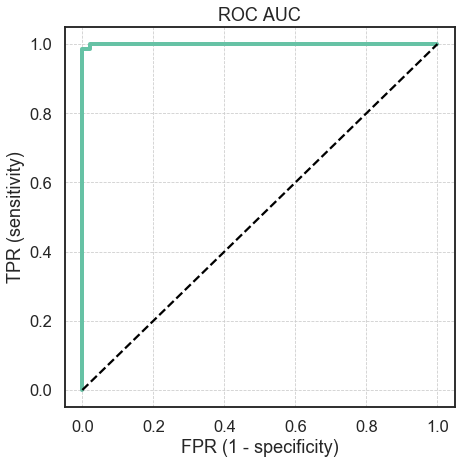

In [51]:
from sklearn import datasets
cancer = datasets.load_breast_cancer()

print("Dimensiones del datset:", cancer.data.shape)

X = cancer.data
y = cancer.target
# Database split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)
# We run the model and then plot the results
y_test, y_score = run_SVM(X_train, X_test, y_train, y_test)

plot_roc_and_swarm(y_true = y_test, y_score = y_score)

# Modelos con CDK2
## Primer modelo
### CSAR (train) / CSAR (test) - Todas las conformaciones
Usamos sólo los resultados del Ensemble Docking con los ligandos de CSAR.

X_train dims: (88, 402)
X_tets dims: (23, 402)

Set de Entrenamiento: 21/88 activos.
Set de Prueba: 5/23 activos.

MÉTRICAS
Accuracy: 1.0
Precision: 1.0
Recall: 1.0

Matriz de confusión:
 [[18  0]
 [ 0  5]]

AUC ROC: 1.0


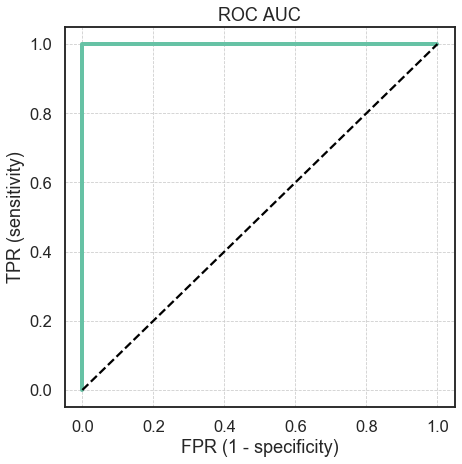

In [52]:
# Split del dataset para obtener train y test
X_train, X_test, y_train, y_test = train_test_split(X_CSAR , y_CSAR, 
                                                    test_size = 0.2, stratify = y_CSAR)
# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train, X_test, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score)

## Segundo Modelo
### CSAR (train) / DUD (test) - Todas las conformaciones
No necesitamos hacer el split, ahora CSAR servirá como conjunto de entrenamiento y validación, y DUD como conjunto de prueba.

X_train dims: (111, 402)
X_tets dims: (2146, 402)

Set de Entrenamiento: 26/111 activos.
Set de Prueba: 72/2146 activos.

MÉTRICAS
Accuracy: 0.9137931034482759
Precision: 0.17341040462427745
Recall: 0.4166666666666667

Matriz de confusión:
 [[1931  143]
 [  42   30]]

AUC ROC: 0.7849766955962714


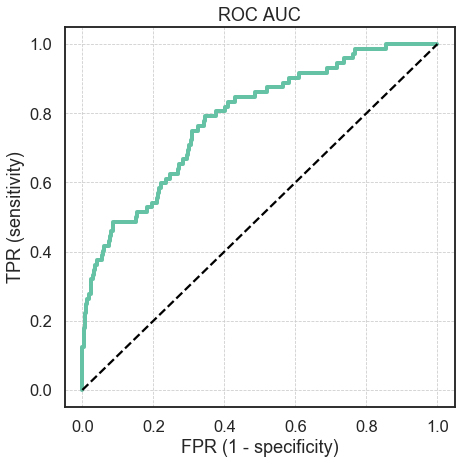

In [53]:
X_train = X_CSAR
y_train = y_CSAR
X_test = X_DUD
y_test = y_DUD

# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train, X_test, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score)

## Tercer Modelo
### CSAR (train) / DUD (test) - Conformaciones del frente  con 5 objetivos
Se incluyen 25 conformaciones

X_train dims: (111, 25)
X_tets dims: (2146, 25)

Set de Entrenamiento: 26/111 activos.
Set de Prueba: 72/2146 activos.

MÉTRICAS
Accuracy: 0.902143522833178
Precision: 0.140625
Recall: 0.375

Matriz de confusión:
 [[1909  165]
 [  45   27]]

AUC ROC: 0.6583828886745955


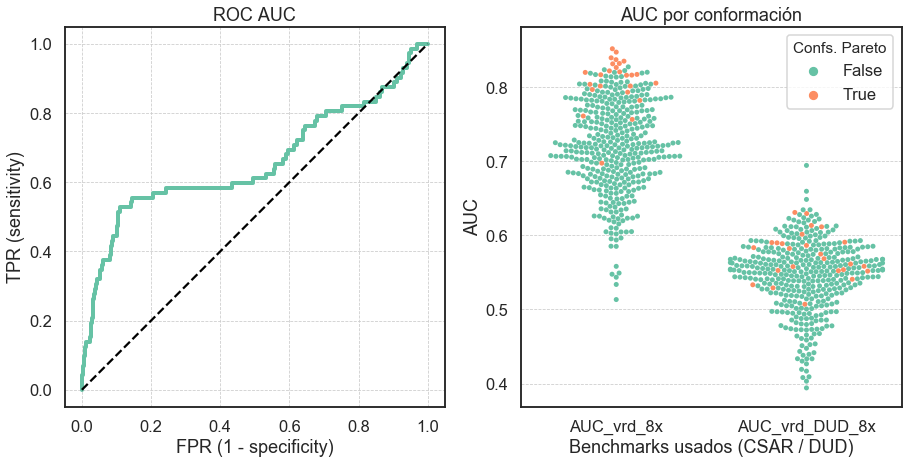

In [54]:
conformaciones_fp_5obj = [ '1ckp', '1h07', '1ke9', '1oiq', '1pxm', '1urw', '1vyz', '2c4g', '2r3p',
       '2r64', '2vv9', '2w05', '3eid', '3ezv', '3lfn', '3qu0', '3s0o', '3s2p',
       '3unj', '3unk', '4bzd', '4cfn', '4eor', '4fkq', '6guf']
filtro = [True if i in conformaciones_fp_5obj else False for i in X_CSAR.columns]

X_train = X_CSAR[ conformaciones_fp_5obj ]
y_train = y_CSAR
X_test = X_DUD[ conformaciones_fp_5obj ]
y_test = y_DUD

y_test, y_score = run_SVM(X_train, X_test, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score, 
                   df = df_auc_scores_vrd8x, mask_filtered_columns = filtro, 
                   filter_name = "Confs. Pareto", plot_swarm= True )

## Cuarto Modelo
### CSAR (train) / DUD (test) - Las 25 mejores conformaciones de vinardo a 16x evaluando CSAR
Se incluyen 25 conformaciones

X_train dims: (111, 25)
X_tets dims: (2146, 25)

Set de Entrenamiento: 26/111 activos.
Set de Prueba: 72/2146 activos.

MÉTRICAS
Accuracy: 0.9496738117427772
Precision: 0.29069767441860467
Recall: 0.3472222222222222

Matriz de confusión:
 [[2013   61]
 [  47   25]]

AUC ROC: 0.633625308046716


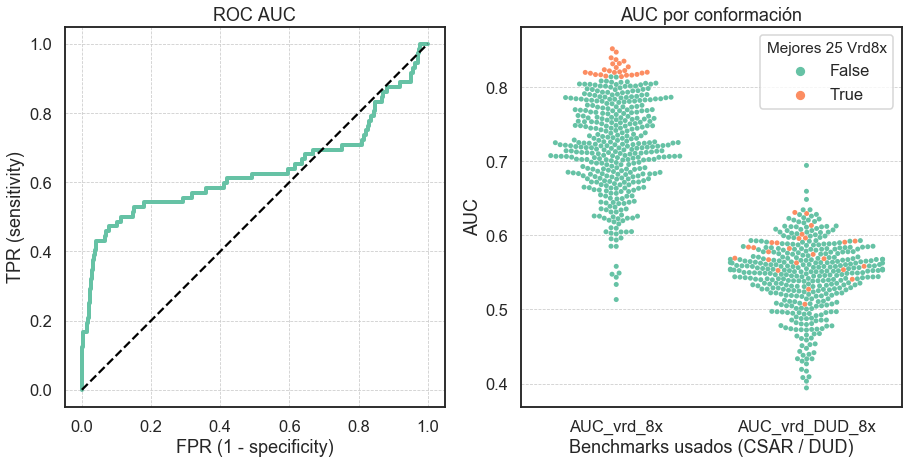

In [55]:
confs_vrd_25_best = df_cdk2_labels.AUC_vrd_8x.sort_values(ascending=False).index[:25]
filtro = [True if i in confs_vrd_25_best else False for i in X_CSAR.columns]

X_train = X_CSAR[ confs_vrd_25_best ]
y_train = y_CSAR

X_test = X_DUD[ confs_vrd_25_best ]
y_test = y_DUD

# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train, X_test, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score, 
                   df = df_auc_scores_vrd8x, mask_filtered_columns = filtro, 
                   filter_name = "Mejores 25 Vrd8x", plot_swarm= True )

## Quinto Modelo
### CSAR (train) / DUD (test) - Mejores conformaciones en DUD evaluado con vinardo 8x

X_train dims: (111, 25)
X_tets dims: (2146, 25)

Set de Entrenamiento: 26/111 activos.
Set de Prueba: 72/2146 activos.

MÉTRICAS
Accuracy: 0.9301025163094129
Precision: 0.2
Recall: 0.3611111111111111

Matriz de confusión:
 [[1970  104]
 [  46   26]]

AUC ROC: 0.6789282652951892


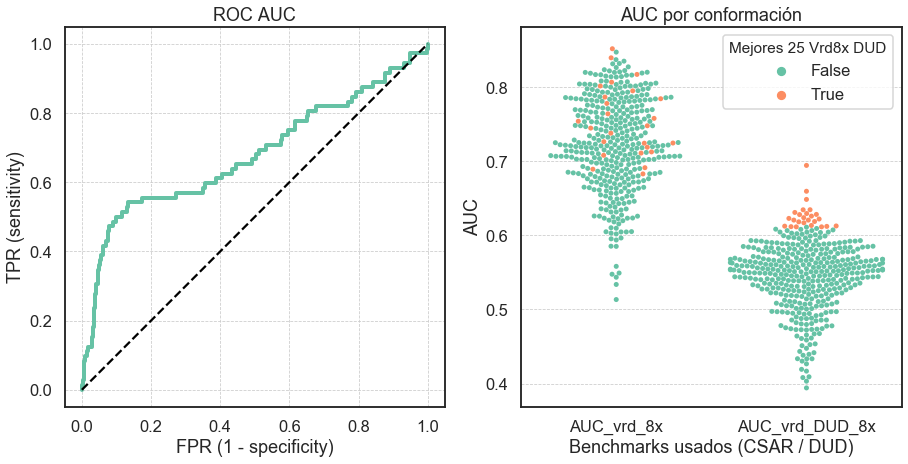

In [56]:
confs_vrd_25_best = df_cdk2_labels.AUC_vrd_DUD_8x.sort_values(ascending=False).index[:25]
filtro = [True if i in confs_vrd_25_best else False for i in X_CSAR.columns]

X_train = X_CSAR[ confs_vrd_25_best ]
y_train = y_CSAR

X_test = X_DUD[ confs_vrd_25_best ]
y_test = y_DUD

# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train, X_test, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score, 
                   df = df_auc_scores_vrd8x, mask_filtered_columns = filtro, 
                   filter_name = "Mejores 25 Vrd8x DUD", plot_swarm= True )

## Sexto Modelo
### CSAR (train) / DUD (test) - Conformaciones con AUC arriba de la media de AUCs con CSAR

In [57]:
df_cdk2_labels.AUC_vrd_8x.describe()

count    402.000000
mean       0.723992
std        0.062214
min        0.513348
25%        0.683258
50%        0.723303
75%        0.773303
max        0.851584
Name: AUC_vrd_8x, dtype: float64

X_train dims: (111, 200)
X_tets dims: (2146, 200)

Set de Entrenamiento: 26/111 activos.
Set de Prueba: 72/2146 activos.

MÉTRICAS
Accuracy: 0.9534016775396086
Precision: 0.2878787878787879
Recall: 0.2638888888888889

Matriz de confusión:
 [[2027   47]
 [  53   19]]

AUC ROC: 0.6606731490410371


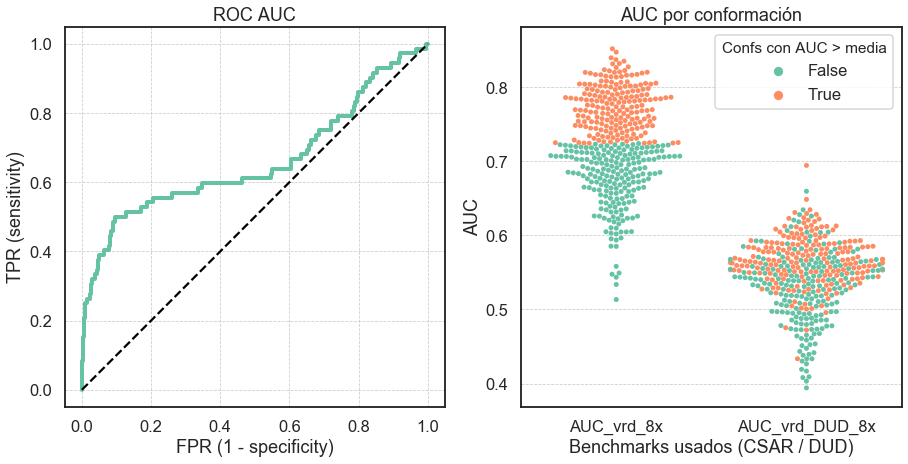

In [58]:
_, media_auc, std_auc, *_ = tuple(df_cdk2_labels.AUC_vrd_8x.describe())
up = media_auc + std_auc
down = media_auc - std_auc
filtro = np.array((df_cdk2_labels.AUC_vrd_8x >= media_auc))

X_train = X_CSAR.iloc[:, filtro ]
y_train = y_CSAR

X_test = X_DUD.iloc[:, filtro ]
y_test = y_DUD

# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train, X_test, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score, 
                   df = df_auc_scores_vrd8x, mask_filtered_columns = filtro, 
                   filter_name = "Confs con AUC > media", plot_swarm= True )

## Séptimo Modelo
### CSAR (train) / DUD (test) - Conformaciones con AUC a +/- 1 sd de la media de AUCs con CSAR

X_train dims: (111, 269)
X_tets dims: (2146, 269)

Set de Entrenamiento: 26/111 activos.
Set de Prueba: 72/2146 activos.

MÉTRICAS
Accuracy: 0.9058713886300093
Precision: 0.14673913043478262
Recall: 0.375

Matriz de confusión:
 [[1917  157]
 [  45   27]]

AUC ROC: 0.7530335904853745


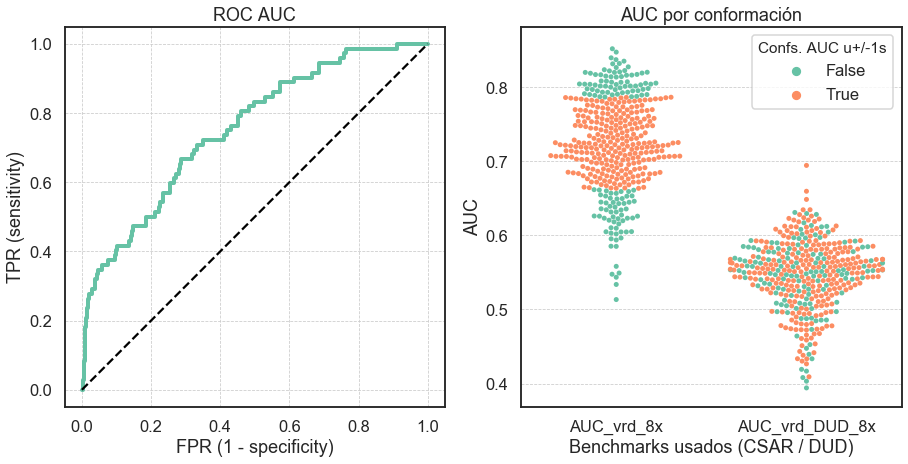

In [59]:
_, media_auc, std_auc, *_ = tuple(df_cdk2_labels.AUC_vrd_8x.describe())
up = media_auc + std_auc
down = media_auc - std_auc
filtro = np.array((df_cdk2_labels.AUC_vrd_8x >= down) & (df_cdk2_labels.AUC_vrd_8x <= up))

X_train = X_CSAR.iloc[:, filtro ]
y_train = y_CSAR

X_test = X_DUD.iloc[:, filtro ]
y_test = y_DUD

# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train, X_test, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score, 
                   df = df_auc_scores_vrd8x, mask_filtered_columns = filtro, 
                   filter_name = "Confs. AUC u+/-1s", plot_swarm= True )

## Octavo Modelo
### CSAR (train) / DUD (test) - Conformaciones activas

X_train dims: (111, 114)
X_tets dims: (2146, 114)

Set de Entrenamiento: 26/111 activos.
Set de Prueba: 72/2146 activos.

MÉTRICAS
Accuracy: 0.8518173345759553
Precision: 0.09271523178807947
Recall: 0.3888888888888889

Matriz de confusión:
 [[1800  274]
 [  44   28]]

AUC ROC: 0.6556908282438658


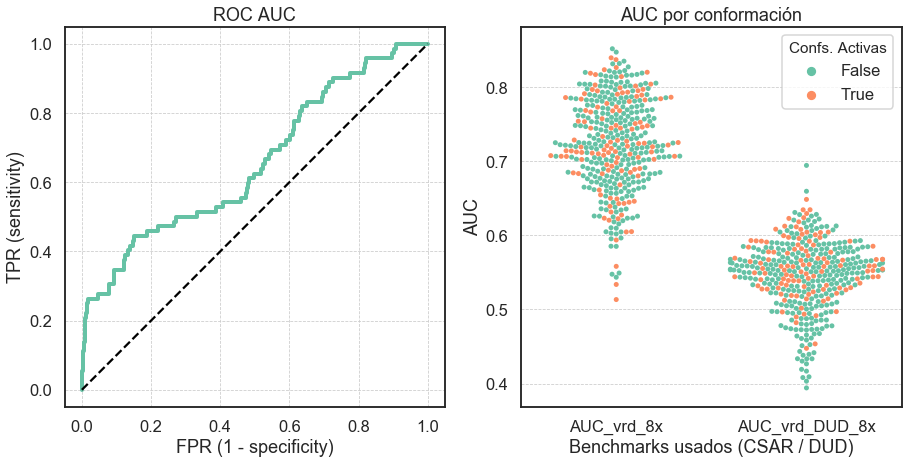

In [60]:
active_confs = df_cdk2_labels[df_cdk2_labels.Labels_conf == "active"].index
filtro = df_cdk2_labels.Labels_conf == "active"
X_train = X_CSAR[ active_confs ]
y_train = y_CSAR

X_test = X_DUD[ active_confs ]
y_test = y_DUD

# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train, X_test, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score, 
                   df = df_auc_scores_vrd8x, mask_filtered_columns = filtro, 
                   filter_name = "Confs. Activas", plot_swarm= True )

## Noveno Modelo
### CSAR (train) / DUD (test) - Conformaciones NO activas

X_train dims: (111, 288)
X_tets dims: (2146, 288)

Set de Entrenamiento: 26/111 activos.
Set de Prueba: 72/2146 activos.

MÉTRICAS
Accuracy: 0.9179869524697111
Precision: 0.18674698795180722
Recall: 0.4305555555555556

Matriz de confusión:
 [[1939  135]
 [  41   31]]

AUC ROC: 0.7968097074895533


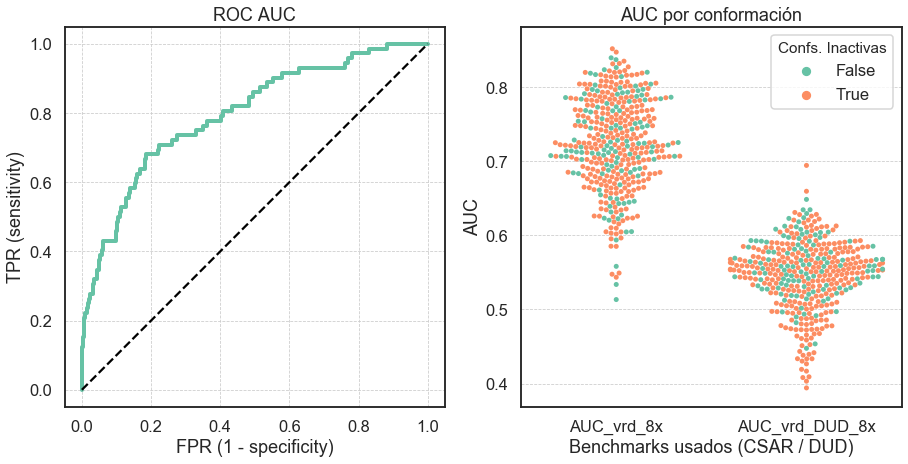

In [61]:
inactive_confs = df_cdk2_labels[df_cdk2_labels.Labels_conf != "active"].index
filtro = df_cdk2_labels.Labels_conf != "active"
X_train = X_CSAR[ inactive_confs  ]
y_train = y_CSAR

X_test = X_DUD[ inactive_confs  ]
y_test = y_DUD

# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train, X_test, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score, 
                   df = df_auc_scores_vrd8x, mask_filtered_columns = filtro, 
                   filter_name = "Confs. Inactivas", plot_swarm= True )

# Feature Selection CSAR DATASET

## Removemos conformaciones con menor varianza
Here in with will use the VarianceThereshold method from sklearn. The method removes all those features whose variance doesn't meet some thereshold, 1.2 in this case.

In [62]:
from sklearn.feature_selection import VarianceThreshold

Number of filtered columns: 140

X_train dims: (111, 140)
X_tets dims: (2146, 140)

Set de Entrenamiento: 26/111 activos.
Set de Prueba: 72/2146 activos.

MÉTRICAS
Accuracy: 0.9147250698974837
Precision: 0.18994413407821228
Recall: 0.4722222222222222

Matriz de confusión:
 [[1929  145]
 [  38   34]]

AUC ROC: 0.7970039108539592


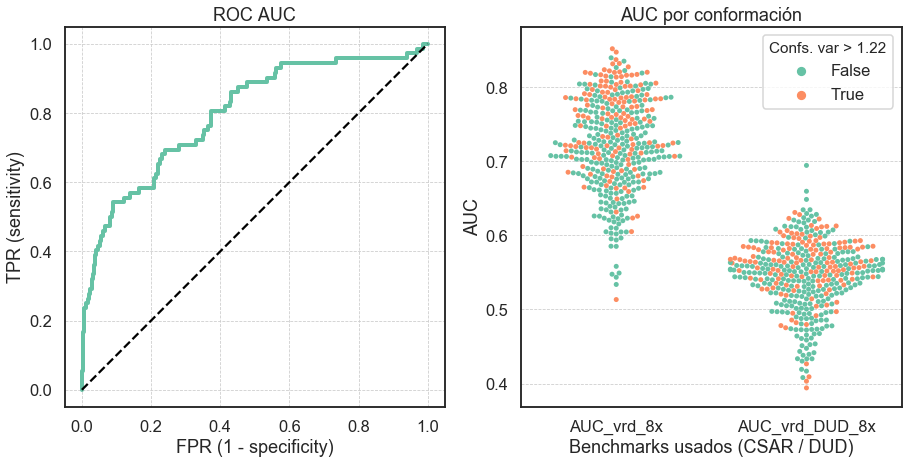

In [63]:
# Definimos los datasets
X_train = X_CSAR
y_train = y_CSAR
X_test = X_DUD
y_test = y_DUD

# Definimos el estimador de varianza unicamente sobre el X_train (CSAR)
sel = VarianceThreshold(threshold = 1.22)
sel.fit_transform(X_train)
filtered_columns = sel.get_support()

print(F'Number of filtered columns: {filtered_columns.sum()}\n')

# Now we update the datasets
X_train_hv = X_train.iloc[:, filtered_columns]
X_test_hv = X_test.iloc[:, filtered_columns]

# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train_hv, X_test_hv, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score, 
                   df = df_auc_scores_vrd8x, mask_filtered_columns = filtered_columns, 
                   filter_name = "Confs. var > 1.22", plot_swarm= True )

# Pendiente:
## Wrapper method Backward elimination
As the name sugest, we fit all the possible features to the model at first. Then we check the performance of the model and then, iteartively remove the worst performing features one by one till the overall performance of the model comes in acceptable range.

Number of filtered columns: 25

X_train dims: (111, 25)
X_tets dims: (2146, 25)

Set de Entrenamiento: 26/111 activos.
Set de Prueba: 72/2146 activos.

MÉTRICAS
Accuracy: 0.9030754892823858
Precision: 0.14583333333333334
Recall: 0.3888888888888889

Matriz de confusión:
 [[1910  164]
 [  44   28]]

AUC ROC: 0.7300104468016715


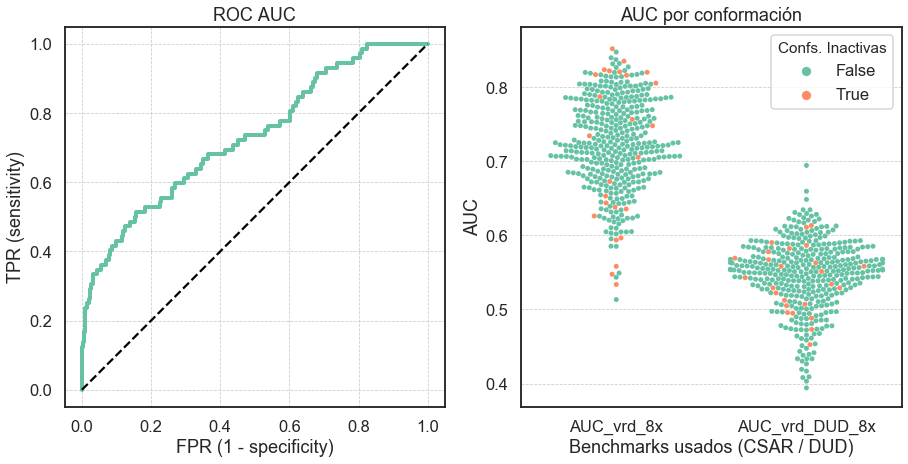

In [64]:
from sklearn.feature_selection import RFE
X_train = X_CSAR
y_train = y_CSAR
X_test = X_DUD
y_test = y_DUD

estimador = SVC(kernel="linear", C = 0.1)
selector = RFE(estimador, n_features_to_select = 25, step = 1)
# Estandarización del X_train para el selector
X_train_std = StandardScaler().fit_transform(X_train)
selector.fit(X_train_std, y_train)
filtered_columns = selector.get_support()

print(F'Number of filtered columns: {filtered_columns.sum()}\n')

# Now we update the datasets
X_train_hv = X_train.iloc[:, filtered_columns]
X_test_hv = X_test.iloc[:, filtered_columns]

# Ejecutamos el SVM
y_test, y_score = run_SVM(X_train_hv, X_test_hv, y_train, y_test)
plot_roc_and_swarm(y_true = y_test, y_score = y_score, 
                   df = df_auc_scores_vrd8x, mask_filtered_columns = filtered_columns, 
                   filter_name = "Confs. Inactivas", plot_swarm= True )